# Basketball Data Analysis Notebook

## Motivation
I created this notebook to showcase my skills with **data cleaning, analysis, and visualization** using common Python libraries such as **pandas, sklearn, and bokeh**.

The code predicts player value in **9-cat H2H fantasy basketball leagues**. In this type of fantasy league, managers face off against another manager each week, and the winner is the manager whose team has a higher sum of points (or higher percentage for FG% and FT%) in a greater number of the following 9 categories during the NBA games that take place that week: *points, assists, rebounds, steals, blocks, 3-pts, field goal %, free throw %, and fewest turnovers*.

The 9-cat H2H fantasy league format presents some challenges. As opposed to points-style leagues where each category is summed with the other categories into one weekly score, 9-cat H2H managers tend to build teams with specific strengths and weaknesses to perform better against managers they find threatening and to ensure that they win the lion's share of categories each week (5 category wins and 4 losses is the same as 9 wins 0 losses). *Trying to draft the best 'all-around' fantasy-point scorers is rarely a winning strategy in competitive categorical H2H leagues.*

## Data Source
For sourcing my data, I used the website [Basketball Reference](basketball-reference.com) to get each notable player's **yearly averages and historical game data** for each season. The website provides each of the 9 categories used in my fantasy league as well as some extra metrics like gamescore (a simple measure of a player's contribution to their team) and plus minus (how their team scores when they are in the game vs out). **I primarily use game data**, as it provides more flexibility and converting to yearly averages is trivial with pandas.

## Strategy
I tried a few different methods, and I encapsulated them into one class to be able to perform analyses on different subsets of the player data on the fly. Rather than try to come up with a singular value metric, I found it more useful to graph each player's expected value for each category (mean) vs the risk of underperforming in a critical moment (std deviation). I also tried a few other strategies such as regression, gradient boosted trees, SVG, and neural networks.

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
import pickle

#####################################################################
## Helper Methods
def make_df_from_rows(data, col_labels):
    '''
        Adds matrix rows to a new DF with given column labels.
        If dict, keys are ignored and values added to axis=0.
    '''
    converted_df = pd.DataFrame([], columns=col_labels)
    if type(data) == list:
        pass
    elif type(data) == dict:
        for key, value in data.items():
            filtered_row = value[[lbl for lbl in col_labels]]
            converted_df = converted_df.append(filtered_row, ignore_index=True)
    
    return converted_df
# df_latest_stats = pd.DataFrame([], columns=yby_numerical_columns)
# for player in latest_stats.keys():
#     player_latest = latest_stats[player][[key for key in yby_numerical_columns]]
#     df_latest_stats = df_latest_stats.append(player_latest, ignore_index=True)
# df_latest_stats = df_latest_stats.replace(pd.NA, 1)

#####################################################################
## Analysis Class
class AnalysisEngine:
    def __init__(self):
        pass
    
    def filter_and_scale(self, stats, col_wts, years, metric):
        filtered_stats = dict()
        player_list = []
        cols_to_keep = [key for key in col_wts.keys()]
        for player in stats:
            if years:
                for year in years:
                    # -1 = newest year for each player
                    if year == -1:
                        if metric == 'std':
                            filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
                        else:
                            filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
                        filtered_stats[player] = filtered_stats[player].loc[[key for key in cols_to_keep]]
                        player_list.append(player)
                        
        df_concat = make_df_from_rows(filtered_stats, cols_to_keep)
        
        # Scale all player means for desired seasons
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(df_concat)
        means_scaled = pd.DataFrame(scaled, columns=cols_to_keep, index=player_list)
        
        for idx, row in means_scaled.iterrows():
            for col, wt in col_wts.items():
                row[col] = row[col] * wt
                        
        return means_scaled

In [47]:
#####################################################################
## Load all yearly stats as pickle files
import os, pickle
stats = dict()
for filename in os.listdir('PlayerPickles/'):
    player_name = filename.replace('YearStats.pkl', '')
    if not os.path.isdir('PlayerPickles/' + filename) and not filename.startswith('.'):
        with open('PlayerPickles/' + filename, 'rb') as yby_pickle:
            stats[player_name] = pickle.load(yby_pickle)

In [48]:
stats['JaylenBrown']

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2016-17,20.0,BOS,NBA,SF,78.0,20.0,17.2,2.5,5.4,...,0.685,0.6,2.2,2.8,0.8,0.4,0.2,0.9,1.8,6.6
1,2017-18,21.0,BOS,NBA,SG,70.0,70.0,30.7,5.3,11.5,...,0.644,0.9,4.0,4.9,1.6,1.0,0.4,1.8,2.6,14.5
2,2018-19,22.0,BOS,NBA,SG,74.0,25.0,25.9,5.0,10.7,...,0.658,0.9,3.4,4.2,1.4,0.9,0.4,1.3,2.5,13.0
3,2019-20,23.0,BOS,NBA,SG,57.0,57.0,33.9,7.5,15.6,...,0.724,1.1,5.3,6.4,2.1,1.1,0.4,2.2,2.9,20.3
4,2020-21,24.0,BOS,NBA,SG,58.0,58.0,34.5,9.3,19.2,...,0.764,1.2,4.8,6.0,3.4,1.2,0.6,2.7,2.9,24.7
5,2021-22,25.0,BOS,NBA,SF,66.0,66.0,33.6,8.7,18.4,...,0.758,0.8,5.3,6.1,3.5,1.1,0.3,2.7,2.5,23.6


In [49]:
#####################################################################
## Get latest season averages for each player
latest_stats = dict()
for player in stats.keys():
    latest_stats[player] = stats[player].iloc[-1]

In [50]:
# Normalize latest season data
yby_numerical_columns = ['G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS']

df_latest_stats = make_df_from_rows(latest_stats, yby_numerical_columns)
df_latest_stats = df_latest_stats.replace(pd.NA, 1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_latest_stats = scaler.fit_transform(df_latest_stats)
scaled_latest_stats = pd.DataFrame(scaled_latest_stats, columns=yby_numerical_columns, index=stats.keys())

scaled_latest_stats

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3734024257.py:19: FutureWarning: The frame.append method is deprecated and will b

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
WillyHernangomez,0.589744,0.097561,0.296667,0.252336,0.215385,0.523179,0.022222,0.017094,0.333,0.295918,...,0.773,0.630435,0.323810,0.439716,0.098039,0.142857,0.142857,0.186047,0.363636,0.258621
GaryHarris,0.730769,0.365854,0.683333,0.299065,0.348718,0.333333,0.422222,0.427350,0.384,0.163265,...,0.874,0.130435,0.085714,0.099291,0.147059,0.428571,0.035714,0.186047,0.333333,0.327586
AndreDrummond,0.256410,0.292683,0.480000,0.401869,0.297436,0.721854,0.000000,0.000000,0.000,0.469388,...,0.537,0.847826,0.561905,0.687943,0.107843,0.380952,0.357143,0.302326,0.696970,0.351724
LaMeloBall,0.910256,0.914634,0.813333,0.607477,0.738462,0.322296,0.644444,0.641026,0.389,0.387755,...,0.872,0.304348,0.447619,0.432624,0.715686,0.714286,0.142857,0.720930,0.757576,0.637931
JarenJacksonJr.,0.948718,0.951220,0.646667,0.448598,0.564103,0.291391,0.355556,0.435897,0.319,0.357143,...,0.823,0.326087,0.361905,0.368794,0.078431,0.380952,0.821429,0.348837,0.848485,0.506897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MasonPlumlee,0.884615,0.890244,0.556667,0.196262,0.107692,0.790287,0.000000,0.000000,0.000,0.244898,...,0.392,0.521739,0.457143,0.503546,0.274510,0.333333,0.250000,0.279070,0.727273,0.168966
JarredVanderbilt,0.897436,0.817073,0.583333,0.205607,0.133333,0.671082,0.000000,0.017094,0.143,0.244898,...,0.656,0.630435,0.476190,0.553191,0.098039,0.571429,0.214286,0.186047,0.515152,0.182759
MalcolmBrogdon,0.410256,0.439024,0.853333,0.570093,0.656410,0.364238,0.355556,0.444444,0.312,0.479592,...,0.856,0.195652,0.352381,0.319149,0.549020,0.333333,0.142857,0.441860,0.393939,0.603448
GabeVincent,0.820513,0.329268,0.516667,0.224299,0.266667,0.295806,0.400000,0.410256,0.368,0.102041,...,0.815,0.065217,0.095238,0.092199,0.274510,0.380952,0.071429,0.279070,0.484848,0.244828


In [ ]:
#######################################################################
## Perform analysis

In [ ]:
# Calculate career averages of each player and store in one dataframe
yby_numerical_columns = ['G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS']

means = pd.DataFrame([], columns=yby_numerical_columns)
for player in stats.keys():
    player_mean = stats[player][[key for key in yby_numerical_columns]].mean()
    means = means.append(player_mean, ignore_index=True)
means = means.replace(pd.NA, 1)
means

In [ ]:
# Normalize the career averages in each cat
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(means)
means_scaled = pd.DataFrame(scaled, columns=yby_numerical_columns, index=stats.keys())

In [ ]:
# Calculate std devs of career stats to be the risk of the player
devs = means = pd.DataFrame([], columns=yby_numerical_columns)
for player in stats.keys():
    player_dev = stats[player][[key for key in yby_numerical_columns]].std()
    devs = devs.append(player_dev, ignore_index=True)
devs = devs.replace(pd.NA, 1)
devs

In [ ]:
# Normalize the career std devs in each cat
dev_scaler = MinMaxScaler()
dev_scaled = dev_scaler.fit_transform(devs)
devs_scaled = pd.DataFrame(dev_scaled, columns=yby_numerical_columns, index=stats.keys())

In [ ]:
# Calculate player risk with desired weights
one_weight_columns = ['FG%', '3P', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'PTS']
relevant_devs = devs_scaled[[key for key in one_weight_columns]]
relevant_devs = pd.concat([relevant_devs, (-1*devs_scaled['TOV']), (2*devs_scaled['G'])], axis=1)

In [ ]:
# Top 12 most risky players
relevant_devs.sum(axis=1).sort_values(ascending=False).head(12)

In [ ]:
# Scale the risk values
risk_scaler = MinMaxScaler()
risk_col = pd.Series(relevant_devs.sum(axis=1)).values.reshape(-1, 1)
risk_scaled = risk_scaler.fit_transform(risk_col)
risk_scaled = pd.Series([value[0] for value in risk_scaled], index=stats.keys())
risk_scaled = risk_scaled.rename('RISK')

In [ ]:
risk_scaled.sort_values(ascending=False).head(5)

In [ ]:
########################################################################
## Generate my own personal rankings

# Take out relevant data subset with desired weights
one_weight_columns = ['FG%', '3P', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'PTS']
relevant_subset = means_scaled[[key for key in one_weight_columns]]
relevant_subset = pd.concat([relevant_subset, (-1*means_scaled['TOV']), (2*means_scaled['G'])], axis=1)
relevant_subset

In [ ]:
# Rank the top 12 players
player_scores = scaled_latest_stats.sum(axis=1)
# risk_scaled

In [ ]:
scaled_latest_stats.loc['Tobias Harris']

In [ ]:
# Bottom 12 players
player_scores.sort_values().head(24)

In [ ]:
# Consider trying to include std dev, probably same way as means and then normalizing the std devs and including in relevant df
# Also right now I am considering career averages, maybe better to weight closer seasons more?

In [ ]:
risk_scaled['James Harden']

In [ ]:
########################################################################
## Try plotting sum against risk
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(16, 12), dpi=80)

plt.plot(player_scores, risk_scaled, 'bo')
for player in stats.keys():
    plt.text(player_scores[player], risk_scaled[player], player)

plt.show()

In [2]:
#####################################################################
## Load All Game Stats
import os, pickle
game_stats = dict()
for filename in os.listdir('PlayerPickles/GameStats/'):
    filename_no_ending = filename.replace('GameStats.pkl', '')
    year = filename_no_ending[len(filename_no_ending) - 4:]
    player = filename_no_ending[:len(filename_no_ending) - 4]
    if player not in game_stats:
        game_stats[player] = dict()
    with open('PlayerPickles/GameStats/' + filename, 'rb') as games_pickle:
        game_stats[player][year] = pickle.load(games_pickle)

In [65]:
########################################################################
## Find Average Game Score for each Player
player_scores = dict()
player_dev = dict()
for player in game_stats.keys():
    last_year = sorted(game_stats[player].keys())[-1]
    player_scores[player] = game_stats[player][last_year]['TRB'].mean()
    player_dev[player] = game_stats[player][last_year]['TRB'].std()

In [66]:
########################################################################
## Normalize scores/deviations
import numpy as np
from sklearn.preprocessing import MinMaxScaler
score_scaler = MinMaxScaler()
scores_scaled = score_scaler.fit_transform(np.array(list(player_scores.values())).reshape(-1, 1))
dev_scaler = MinMaxScaler()
devs_scaled = dev_scaler.fit_transform(np.array(list(player_dev.values())).reshape(-1, 1))

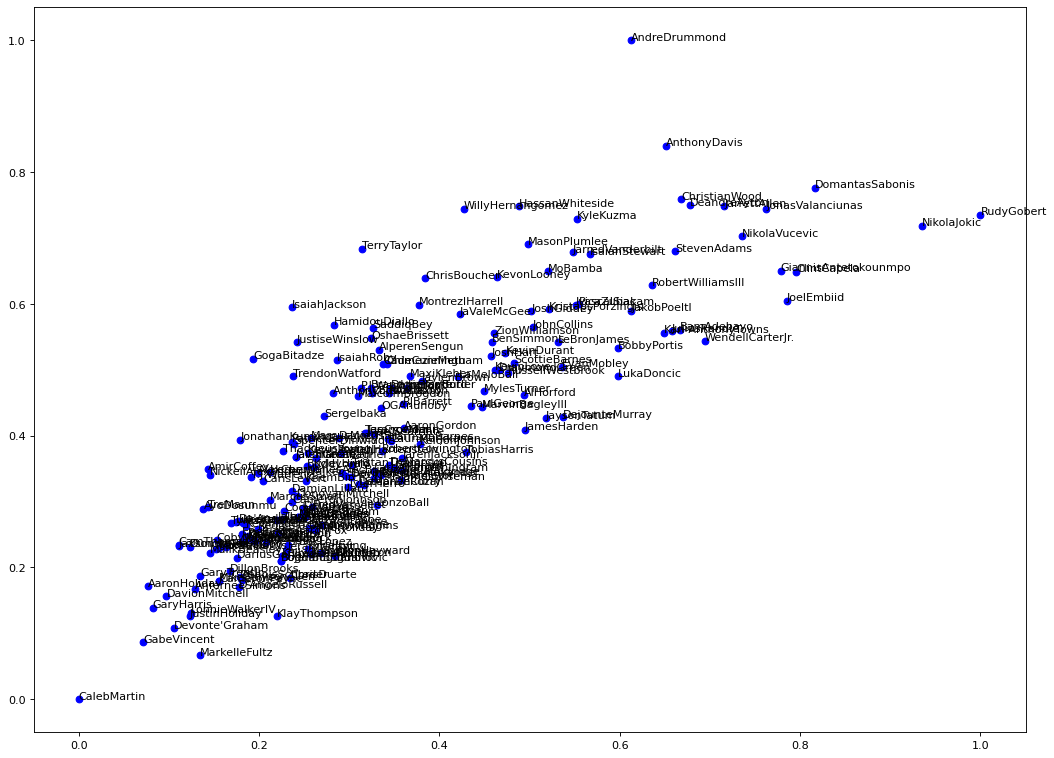

In [67]:
########################################################################
## Try plotting game score vs std dev game score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(16, 12), dpi=80)

plt.plot(scores_scaled, devs_scaled, 'bo')
players_list = list(player_scores.keys())
for player in players_list:
    idx = players_list.index(player)
    plt.text(scores_scaled[idx], devs_scaled[idx], player)

plt.show()

In [68]:
player_scores['KyrieIrving']

4.379310344827586

In [69]:
game_stats['KyrieIrving']['2022'].PTS.mean()

27.448275862068964

In [70]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()

source = ColumnDataSource(
        data=dict(
            x=scores_scaled,
            y=devs_scaled,
            desc=players_list,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover],
           title="Mouse over the dots")

p.circle('x', 'y', size=10, source=source)
show(p)

Loading BokehJS ...

In [55]:
scaled_latest_stats.sort_values(by=['3P']).tail(20)

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
PaulGeorge,0.346154,0.378049,0.893333,0.738318,0.933333,0.304636,0.644444,0.709402,0.354,0.540816,...,0.858,0.086957,0.571429,0.446809,0.529412,1.000000,0.142857,0.906977,0.515152,0.782759
LaMeloBall,0.910256,0.914634,0.813333,0.607477,0.738462,0.322296,0.644444,0.641026,0.389,0.387755,...,0.872,0.304348,0.447619,0.432624,0.715686,0.714286,0.142857,0.720930,0.757576,0.637931
JaysonTatum,0.923077,0.926829,0.933333,0.803738,0.938462,0.375276,0.666667,0.735043,0.353,0.602041,...,0.853,0.239130,0.609524,0.524823,0.401961,0.428571,0.214286,0.627907,0.484848,0.872414
GaryTrentJr.,0.846154,0.841463,0.903333,0.532710,0.676923,0.289183,0.666667,0.666667,0.383,0.306122,...,0.853,0.086957,0.180952,0.148936,0.166667,0.761905,0.107143,0.186047,0.424242,0.575862
AnthonyEdwards,0.871795,0.878049,0.880000,0.644860,0.769231,0.348786,0.666667,0.717949,0.357,0.428571,...,0.786,0.195652,0.323810,0.297872,0.343137,0.666667,0.214286,0.558140,0.484848,0.679310
DesmondBane,0.923077,0.926829,0.730000,0.560748,0.625641,0.392936,0.666667,0.589744,0.436,0.336735,...,0.903,0.130435,0.314286,0.269504,0.235294,0.523810,0.142857,0.302326,0.575758,0.572414
TerryRozier,0.884615,0.890244,0.860000,0.598131,0.702564,0.355408,0.666667,0.692308,0.374,0.377551,...,0.852,0.173913,0.285714,0.262411,0.411765,0.571429,0.107143,0.255814,0.272727,0.610345
MalikBeasley,0.961538,0.219512,0.570000,0.327103,0.435897,0.238411,0.666667,0.692308,0.377,0.081633,...,0.817,0.065217,0.190476,0.163121,0.117647,0.190476,0.071429,0.069767,0.121212,0.362069
AnferneeSimons,0.679487,0.365854,0.720000,0.514019,0.600000,0.353201,0.688889,0.666667,0.405,0.275510,...,0.888,0.108696,0.161905,0.141844,0.352941,0.190476,0.035714,0.418605,0.363636,0.541379
BuddyHield,0.282051,0.317073,0.923333,0.588785,0.682051,0.362031,0.688889,0.726496,0.362,0.357143,...,0.886,0.195652,0.352381,0.319149,0.441176,0.428571,0.142857,0.511628,0.606061,0.572414


In [58]:
game_stats['ZionWilliamson']['2021'].std()

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/1524783458.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  game_stats['ZionWilliamson']['2021'].std()


G       17.752934
GS       0.000000
FG       2.865186
FGA      4.301163
FG%      0.133303
3P       0.373288
3PA      0.764299
3P%      0.330796
FT       2.397403
FTA      3.457944
FT%      0.162422
ORB      1.740705
DRB      2.507475
TRB      3.237249
AST      2.216185
STL      1.093448
BLK      0.817166
TOV      1.682277
PF       1.212638
PTS      6.292853
GmSc     6.700837
+/-      6.292853
dtype: float64

In [62]:
test = dict()
for player in game_stats:
    test[player] = game_stats[player][sorted(game_stats[player].keys())[-1]].std().sum()

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_2169/3608357320.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test[player] = game_stats[player][sorted(game_stats[player].keys())[-1]].std().sum()


In [63]:
dict(sorted(test.items(), key=lambda item: item[1]))

{'CameronJohnson': 23.354382571412106,
 'PattyMills': 38.140925517056075,
 'MarkelleFultz': 40.069735286651245,
 'CamThomas': 40.6057492000674,
 'ThomasBryant': 42.94623831370986,
 'KhemBirch': 45.467793939467256,
 'LarryNanceJr.': 47.274559448894486,
 'BrookLopez': 48.734374707496656,
 'TristanThompson': 49.15921321845926,
 'JamesWiseman': 50.216343951584896,
 'ThaddeusYoung': 50.557010709047795,
 'NicClaxton': 50.60318933287677,
 'DraymondGreen': 50.607900936267775,
 'KeldonJohnson': 50.67115916592028,
 'AlexCaruso': 51.67441173448162,
 'CalebMartin': 51.71938623549567,
 'DanielTheis': 52.07480189577914,
 'LonzoBall': 52.320751213425886,
 'KellyOlynyk': 52.325696900397766,
 'MasonPlumlee': 53.46795385311516,
 'SergeIbaka': 53.77024711920448,
 'AaronHoliday': 54.07586348065227,
 'JalenGreen': 54.79317765790664,
 'JavonteGreen': 54.79317765790664,
 'DillonBrooks': 54.953083959587346,
 'JustiseWinslow': 54.98405842262802,
 'TerryTaylor': 55.010569266403664,
 'RobertWilliamsIII': 55.0596

In [41]:
holistic_metric = {
    'PTS': 1,
    'TRB': 1,
    'AST': 1,
    'STL': 1,
    'BLK': 1,
    '3P': 1,
    'G': 1,
#     'FG': 1,
#     'FT': 1,
    'TOV': -1
}
holistic_metric_std = {
    'PTS': 1,
    'TRB': 1,
    'AST': 1,
    'STL': 1,
    'BLK': 1,
    '3P': 1,
#     'FG': 1,
#     'FT': 1,
    'TOV': -1
}

engine = AnalysisEngine()
df_scaled = engine.filter_and_scale(game_stats, holistic_metric, [-1], 'mean')
df_scaled_std = engine.filter_and_scale(game_stats, holistic_metric_std, [-1], 'std')

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Sele

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Sele

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Sele

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Sele

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Sele

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Sele

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].mean()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:47: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Sele

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  filtered_stats[player] = stats[player][sorted(stats[player].keys())[-1]].std()
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:45: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will b

/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  converted_df = converted_df.append(filtered_row, ignore_index=True)
/var/folders/bq/h7ljfy0x5jng5l25x9j79_0h0000gn/T/ipykernel_1703/1709691338.py:20: FutureWarning: The frame.append method is deprecated and will b

In [42]:
df_sum = df_scaled.sum(axis=1)
df_sum_std = df_scaled_std.sum(axis=1)
player_names = df_sum.index

In [43]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()

source = ColumnDataSource(
        data=dict(
            x=df_sum,
            y=df_sum_std,
            desc=player_names,
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover],
           title="Mouse over the dots")

p.circle('x', 'y', size=10, source=source)
show(p)

Loading BokehJS ...

$$c = \sqrt{a^2 + b^2}$$